# Google Location Review Quality Assessment - Hybrid Model with LoRA


##INSTALLATION AND IMPORTS

In [46]:
!pip install -q transformers peft accelerate torch scikit-learn datasets

import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from datetime import datetime, timedelta


from transformers import (
    AutoTokenizer,
    AutoModel,
    TrainingArguments,
    TrainerCallback,
    TrainerState,
    TrainerControl,
    Trainer,
    AutoConfig,
    get_scheduler
)

from peft import LoraConfig, get_peft_model, TaskType
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##CONFIGURATION

In [47]:
"""##ENHANCED CONFIGURATION WITH ADVANCED TRAINING FEATURES"""

CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 512,
    'num_labels': 4,
    'batch_size': 16,
    'num_epochs': 100,  # Increased since we'll use early stopping
    'learning_rate': 2e-5,
    'base_path': '/content/drive/MyDrive/Tiktok_Hackaton/',
    'use_mock_data': False,

    # Advanced training features
    'early_stopping': {
        'enabled': True,
        'patience': 3,
        'min_delta': 0.001,
        'metric_for_best_model': 'eval_f1',
        'greater_is_better': True
    },

    'learning_rate_scheduler': {
        'enabled': True,
        'scheduler_type': 'cosine_with_restarts',  # 'linear', 'cosine', 'cosine_with_restarts'
        'warmup_ratio': 0.1,
        'num_cycles': 1  # For cosine with restarts
    },

    'gradient_clipping': {
        'enabled': True,
        'max_grad_norm': 1.0
    },

    'mixed_precision': {
        'enabled': True,
        'fp16': True  # Set to False if using older GPUs
    },

    'data_augmentation': {
        'enabled': False,  # Can enable for text augmentation
        'augmentation_probability': 0.1
    },

    'regularization': {
        'weight_decay': 0.01,
        'dropout_rate': 0.1,
        'layer_wise_lr_decay': 0.9  # Different LR for different layers
    },

    'logging_and_saving': {
        'logging_steps': 50,
        'eval_steps': 100,
        'save_steps': 500,
        'save_total_limit': 3,  # Keep only best 3 checkpoints
        'load_best_model_at_end': True,
        'logging_first_step': True
    },

    # Mock data configuration (unchanged)
    'mock_data': {
        'num_samples': 1000,
        'train_split': 0.7,
        'val_split': 0.15,
        'test_split': 0.15,
        'random_seed': 42
    },

    # Categorical feature vocabulary sizes (for mock data)
    'categorical_vocab_sizes': [5, 7, 24, 10],

    # Model architecture
    'lora_config': {
        'r': 8,
        'lora_alpha': 16,
        'lora_dropout': 0.05
    },

    'class_weighting': {
        'enabled': True,
        'method': 'balanced_smoothed',  # Try 'balanced_smoothed' or 'sqrt_balanced' for less extreme weights
        'label_smoothing': 0.1,
        'smoothing_factor': 0.1  # For balanced_smoothed method
    },
}

def get_categorical_vocab_sizes(datasets, metadata):
    """Dynamically calculate vocabulary sizes from real data"""
    if CONFIG['use_mock_data']:
        return CONFIG['categorical_vocab_sizes']
    else:
        # Calculate from actual data
        vocab_sizes = []
        train_cat_features = np.array(datasets['train']['categorical_features'])

        for feature_idx in range(train_cat_features.shape[1]):
            max_val = int(train_cat_features[:, feature_idx].max()) + 1
            vocab_sizes.append(max_val)

        print(f"Calculated vocab sizes: {vocab_sizes}")
        return vocab_sizes

def get_device():
  if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA GPU: {torch.cuda.get_device_name()}")
  elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU (MPS)")
  else:
    device = torch.device('cpu')
    print("Using CPU")
  return device

device = get_device()

Using CUDA GPU: NVIDIA A100-SXM4-40GB


##MOCK DATA GENERATION (for testing while preprocessing is in progress)

In [48]:
def create_mock_features():
    """Create mock features matching your actual feature set"""
    np.random.seed(42)

    # Categorical features (encoded)
    categorical_features = [
        np.random.randint(0, 5, 1000),    # review_vs_business_category (0-4)
        np.random.randint(0, 7, 1000),    # day_of_week (0-6)
        np.random.randint(0, 24, 1000),   # hour_of_day (0-23)
        np.random.randint(0, 10, 1000),   # dominant_topic (0-9)
    ]

    # Continuous features (normalized)
    continuous_features = [
        np.random.normal(0, 1, 1000),     # user_review_count (normalized)
        np.random.normal(0, 1, 1000),     # avg_review_rating (normalized)
        np.random.randint(0, 2, 1000),    # contains_url (binary)
        np.random.normal(0, 1, 1000),     # num_same_day_reviews (normalized)
        np.random.uniform(-1, 1, 1000),   # sentiment_score (-1 to 1)
        np.random.normal(0, 1, 1000),     # review_length (normalized)
        np.random.normal(0, 1, 1000),     # tfidf_feature_1
        np.random.normal(0, 1, 1000),     # tfidf_feature_2
        np.random.normal(0, 1, 1000),     # tfidf_feature_3
    ]

    return np.array(categorical_features).T, np.array(continuous_features).T

In [49]:
def create_mock_data():
    """Generate mock data for testing"""
    print("Creating mock data...")

    # Generate features
    cat_features, cont_features = create_mock_features()

    # Generate mock review texts
    review_templates = [
        "This restaurant has excellent food and great service. Highly recommend!",
        "Terrible experience. Staff was rude and food was cold. Never going back.",
        "Average place, nothing special but decent for the price.",
        "SPAM: Visit our website for amazing deals! Click here now!",
        "Just complaining about life in general, not about this place specifically.",
        "The ambiance was nice and the location is convenient for shopping."
    ]

    review_texts = [np.random.choice(review_templates) for _ in range(1000)]

    # Generate labels (0: Spam, 1: Irrelevant, 2: Rant, 3: Quality)
    labels = np.random.choice([0, 1, 2, 3], 1000, p=[0.1, 0.15, 0.25, 0.5])

    # Split data
    split_1 = int(0.7 * 1000)  # 70% train
    split_2 = int(0.85 * 1000) # 15% val, 15% test

    datasets = {
        'train': {
            'review_text': review_texts[:split_1],
            'categorical_features': cat_features[:split_1].tolist(),
            'continuous_features': cont_features[:split_1].tolist(),
            'labels': labels[:split_1].tolist(),
            'review_id': [f'mock_{i}' for i in range(split_1)]
        },
        'val': {
            'review_text': review_texts[split_1:split_2],
            'categorical_features': cat_features[split_1:split_2].tolist(),
            'continuous_features': cont_features[split_1:split_2].tolist(),
            'labels': labels[split_1:split_2].tolist(),
            'review_id': [f'mock_{i}' for i in range(split_1, split_2)]
        },
        'test': {
            'review_text': review_texts[split_2:],
            'categorical_features': cat_features[split_2:].tolist(),
            'continuous_features': cont_features[split_2:].tolist(),
            'labels': labels[split_2:].tolist(),
            'review_id': [f'mock_{i}' for i in range(split_2, 1000)]
        }
    }

    # Mock metadata
    metadata = {
        "categorical_features": {
            "feature_names": ["review_vs_business_category", "day_of_week", "hour_of_day", "dominant_topic"],
            "feature_dim": 4
        },
        "continuous_features": {
            "feature_names": [
                "user_review_count", "avg_review_rating", "contains_url",
                "num_same_day_reviews", "sentiment_score", "review_length",
                "tfidf_feature_1", "tfidf_feature_2", "tfidf_feature_3"
            ],
            "feature_dim": 9
        },
        "num_labels": 4,
        "label_mapping": {
            "Spam/Advertisement": 0,
            "Irrelevant Content": 1,
            "Rant/Complaint (without visit)": 2,
            "Relevant and Quality": 3
        },
        "text_max_length": 512
    }

    return datasets, metadata

##DATA LOADING

In [50]:
def load_data():
    """Load data (mock or real)"""
    if CONFIG['use_mock_data']:
        print("Using mock data for testing...")
        return create_mock_data()
    else:
        print("Loading preprocessed data...")
        base_path = CONFIG['base_path'] + 'preprocessed_data/'

        # Load datasets
        datasets = {}
        for split in ['train', 'val', 'test']:
            with open(f'{base_path}processed_{split}.pkl', 'rb') as f:
                datasets[split] = pickle.load(f)

        # Load metadata
        with open(f'{base_path}feature_metadata.json', 'r') as f:
            metadata = json.load(f)

        return datasets, metadata

##DATASET CLASS

In [51]:
class ReviewDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, feature_keys=None):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Allow flexible feature key names
        self.feature_keys = feature_keys or {
            'text': 'review_text',
            'categorical': 'categorical_features',
            'continuous': 'continuous_features',
            'labels': 'labels'
        }

    def __len__(self):
        return len(self.data[self.feature_keys['text']])

    def __getitem__(self, idx):
        # Tokenize text
        text = str(self.data[self.feature_keys['text']][idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'categorical_features': torch.tensor(
                self.data[self.feature_keys['categorical']][idx],
                dtype=torch.long
            ),
            'continuous_features': torch.tensor(
                self.data[self.feature_keys['continuous']][idx],
                dtype=torch.float
            ),
            'labels': torch.tensor(
                self.data[self.feature_keys['labels']][idx],
                dtype=torch.long
            )
        }

In [52]:
def calculate_class_weights(train_labels, method='balanced', device='cpu', smoothing_factor=0.1):
    """Calculate class weights for imbalanced dataset with optional smoothing"""

    # Convert to numpy if needed
    if isinstance(train_labels, list):
        train_labels = np.array(train_labels)

    unique_labels = np.unique(train_labels)
    n_classes = len(unique_labels)

    if method == 'balanced':
        # Use sklearn's balanced approach
        class_weights = compute_class_weight(
            'balanced',
            classes=unique_labels,
            y=train_labels
        )
        weights_dict = dict(zip(unique_labels, class_weights))

    elif method == 'balanced_smoothed':
        # Smoothed version to avoid extreme weights
        class_counts = np.bincount(train_labels, minlength=n_classes)
        total_samples = len(train_labels)

        # Add smoothing to avoid extreme weights
        smoothed_counts = class_counts + smoothing_factor * total_samples / n_classes
        class_weights = total_samples / (n_classes * smoothed_counts)
        weights_dict = {i: class_weights[i] for i in range(n_classes)}

    elif method == 'inverse_freq':
        # Inverse frequency weighting
        class_counts = np.bincount(train_labels, minlength=n_classes)
        total_samples = len(train_labels)
        class_weights = total_samples / (n_classes * class_counts)
        weights_dict = {i: class_weights[i] for i in range(n_classes)}

    elif method == 'sqrt_balanced':
        # Square root of inverse frequency (less extreme)
        class_counts = np.bincount(train_labels, minlength=n_classes)
        total_samples = len(train_labels)
        class_weights = np.sqrt(total_samples / (n_classes * class_counts))
        weights_dict = {i: class_weights[i] for i in range(n_classes)}

    else:  # manual - equal weights
        weights_dict = {i: 1.0 for i in range(n_classes)}

    # Convert to tensor and ensure all classes are represented
    weights_tensor = torch.zeros(n_classes, dtype=torch.float32)
    for class_idx in range(n_classes):
        weights_tensor[class_idx] = weights_dict.get(class_idx, 1.0)

    weights_tensor = weights_tensor.to(device)

    print(f"📊 Class weights ({method}):")
    for i, weight in enumerate(weights_tensor):
        print(f"   Class {i}: {weight:.4f}")

    return weights_tensor

# MODEL DEFINITION

In [53]:
class HybridClassificationModel(nn.Module):
    def __init__(self, num_labels, categorical_feature_dim, continuous_feature_dim,
                 categorical_vocab_sizes=None, dropout_rate=0.1, class_weights=None):
        super(HybridClassificationModel, self).__init__()

        # Store class weights
        self.register_buffer('class_weights', class_weights)

        # Text branch (DistilBERT with LoRA)
        self.distilbert = AutoModel.from_pretrained(CONFIG['model_name'])

        lora_config = LoraConfig(
            r=CONFIG['lora_config']['r'],
            lora_alpha=CONFIG['lora_config']['lora_alpha'],
            target_modules=["q_lin", "k_lin", "v_lin"],
            lora_dropout=CONFIG['lora_config']['lora_dropout'],
            bias="none",
            task_type=TaskType.FEATURE_EXTRACTION
        )
        self.distilbert = get_peft_model(self.distilbert, lora_config)

        distilbert_hidden_size = self.distilbert.config.hidden_size  # 768

        # Dynamic categorical embeddings
        if categorical_vocab_sizes is None:
            categorical_vocab_sizes = [5, 7, 24, 10]

        self.categorical_embeddings = nn.ModuleList([
            nn.Embedding(vocab_size, min(50, vocab_size // 2 + 10))
            for vocab_size in categorical_vocab_sizes
        ])

        # Calculate total embedding dimension
        total_cat_embed_dim = sum(emb.embedding_dim for emb in self.categorical_embeddings)

        # Enhanced categorical processing with batch norm
        self.categorical_ffn = nn.Sequential(
            nn.Linear(total_cat_embed_dim, distilbert_hidden_size),
            nn.BatchNorm1d(distilbert_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Enhanced continuous features branch with batch norm
        self.continuous_ffn = nn.Sequential(
            nn.Linear(continuous_feature_dim, distilbert_hidden_size // 2),
            nn.BatchNorm1d(distilbert_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(distilbert_hidden_size // 2, distilbert_hidden_size),
            nn.BatchNorm1d(distilbert_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Enhanced final classifier with multiple layers
        combined_size = distilbert_hidden_size * 3
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, distilbert_hidden_size),
            nn.BatchNorm1d(distilbert_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(distilbert_hidden_size, distilbert_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(distilbert_hidden_size // 2, num_labels)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.xavier_uniform_(module.weight)

    def forward(self, input_ids, attention_mask, categorical_features, continuous_features, labels=None):
        batch_size = input_ids.size(0)

        # Text branch
        text_outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        text_hidden = text_outputs.last_hidden_state[:, 0, :]

        # Categorical branch
        cat_embeddings = []
        for i, embedding_layer in enumerate(self.categorical_embeddings):
            feature_embedded = embedding_layer(categorical_features[:, i])
            cat_embeddings.append(feature_embedded)

        cat_combined = torch.cat(cat_embeddings, dim=-1)
        cat_processed = self.categorical_ffn(cat_combined)

        # Continuous branch
        cont_processed = self.continuous_ffn(continuous_features)

        # Combine all branches
        combined_features = torch.cat((text_hidden, cat_processed, cont_processed), dim=-1)
        logits = self.classifier(combined_features)

        loss = None
        if labels is not None:
            # Use the stored class weights
            loss_fct = nn.CrossEntropyLoss(
                weight=self.class_weights,
                label_smoothing=CONFIG['class_weighting']['label_smoothing']
            )
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

## Early Stopping Callback

In [54]:
"""##EARLY STOPPING CALLBACK"""


from transformers import TrainerCallback, TrainerState

class EarlyStoppingCallback(TrainerCallback):
    """
    Enhanced early stopping callback with more features
    """
    def __init__(self,
                 early_stopping_patience: int = 3,
                 early_stopping_threshold: float = 0.001,
                 metric_for_best_model: str = "eval_f1",
                 greater_is_better: bool = True):

        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.metric_for_best_model = metric_for_best_model
        self.greater_is_better = greater_is_better

        self.best_metric = None
        self.best_epoch = None
        self.patience_counter = 0

    def on_evaluate(self, args, state: TrainerState, control, logs=None, model=None, **kwargs):
        # Handle the case where logs is not a dictionary or doesn't contain the metric.
        if logs is None or self.metric_for_best_model not in logs:
            return

        current_metric = logs.get(self.metric_for_best_model)

        # Initialize best metric on first evaluation
        if self.best_metric is None:
            self.best_metric = current_metric
            self.best_epoch = state.epoch
            return

        # Check if the new metric is a significant improvement.
        # This is the core fix. The logic must handle both greater_is_better=True and False.
        if self.greater_is_better:
            is_significant_improvement = current_metric > self.best_metric + self.early_stopping_threshold
        else: # smaller is better
            is_significant_improvement = current_metric < self.best_metric - self.early_stopping_threshold

        if is_significant_improvement:
            # New best model
            self.best_metric = current_metric
            self.best_epoch = state.epoch
            self.patience_counter = 0
            print(f"🎯 New best {self.metric_for_best_model}: {current_metric:.4f} at epoch {int(state.epoch)}")
        else:
            # No improvement
            self.patience_counter += 1
            print(f"⏳ No improvement for {self.patience_counter}/{self.early_stopping_patience} evaluations")

            if self.patience_counter >= self.early_stopping_patience:
                print(f"🛑 Early stopping triggered! Best {self.metric_for_best_model}: {self.best_metric:.4f} at epoch {int(self.best_epoch)}")
                control.should_training_stop = True

##Custom Trainer

In [55]:
class EnhancedCustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        # Initialize loss function with class weights
        self.loss_fct = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=CONFIG['class_weighting']['label_smoothing']
        )

    def create_optimizer(self):
        """Create optimizer with layer-wise learning rate decay"""
        if self.optimizer is None:
            decay_parameters = []
            no_decay_parameters = []

            # Group parameters by layer for different learning rates
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    if any(nd in name for nd in ["bias", "LayerNorm", "BatchNorm"]):
                        no_decay_parameters.append(param)
                    else:
                        decay_parameters.append(param)

            optimizer_grouped_parameters = [
                {
                    "params": decay_parameters,
                    "weight_decay": CONFIG['regularization']['weight_decay'],
                    "lr": self.args.learning_rate,
                },
                {
                    "params": no_decay_parameters,
                    "weight_decay": 0.0,
                    "lr": self.args.learning_rate,
                }
            ]

            self.optimizer = AdamW(
                optimizer_grouped_parameters,
                lr=self.args.learning_rate,
                betas=(0.9, 0.999),
                eps=1e-8,
            )

        return self.optimizer

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Enhanced compute loss with weighted loss function"""
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")

        # Use the weighted loss function
        loss = self.loss_fct(logits, labels)

        # Add L2 regularization to embeddings (optional)
        l2_reg = 0
        for name, param in model.named_parameters():
            if 'embedding' in name and param.requires_grad:
                l2_reg += torch.norm(param)

        loss = loss + 1e-6 * l2_reg  # Small L2 penalty

        return (loss, outputs) if return_outputs else loss

    def training_step(self, model, inputs, num_items_in_batch=None):
        """Enhanced training step with gradient clipping"""
        model.train()
        inputs = self._prepare_inputs(inputs)

        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)

        if self.args.n_gpu > 1:
            loss = loss.mean()

        self.accelerator.backward(loss)

        return loss.detach() / self.args.gradient_accumulation_steps


##Metrics

In [56]:
def compute_enhanced_metrics(eval_pred):
    """Compute comprehensive metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Basic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, predictions, average=None
    )

    # Macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )

    # Class distribution in predictions
    unique, counts = np.unique(predictions, return_counts=True)
    pred_distribution = dict(zip(unique.tolist(), counts.tolist()))

    return {
        'accuracy': accuracy,
        'f1': f1,
        'f1_macro': f1_macro,
        'precision': precision,
        'precision_macro': precision_macro,
        'recall': recall,
        'recall_macro': recall_macro,

        # Per-class metrics (for 4 classes)
        'f1_class_0': f1_per_class[0] if len(f1_per_class) > 0 else 0,
        'f1_class_1': f1_per_class[1] if len(f1_per_class) > 1 else 0,
        'f1_class_2': f1_per_class[2] if len(f1_per_class) > 2 else 0,
        'f1_class_3': f1_per_class[3] if len(f1_per_class) > 3 else 0,

        'precision_class_0': precision_per_class[0] if len(precision_per_class) > 0 else 0,
        'precision_class_1': precision_per_class[1] if len(precision_per_class) > 1 else 0,
        'precision_class_2': precision_per_class[2] if len(precision_per_class) > 2 else 0,
        'precision_class_3': precision_per_class[3] if len(precision_per_class) > 3 else 0,

        'recall_class_0': recall_per_class[0] if len(recall_per_class) > 0 else 0,
        'recall_class_1': recall_per_class[1] if len(recall_per_class) > 1 else 0,
        'recall_class_2': recall_per_class[2] if len(recall_per_class) > 2 else 0,
        'recall_class_3': recall_per_class[3] if len(recall_per_class) > 3 else 0,
    }

##Training pipeline

In [57]:
"""##ENHANCED TRAINING PIPELINE"""

def create_training_arguments():
    """Create enhanced training arguments with all features"""
    return TrainingArguments(
        output_dir=CONFIG['base_path'] + 'results',
        num_train_epochs=CONFIG['num_epochs'],
        per_device_train_batch_size=CONFIG['batch_size'],
        per_device_eval_batch_size=CONFIG['batch_size'],

        # Learning rate and scheduling
        learning_rate=CONFIG['learning_rate'],
        lr_scheduler_type=CONFIG['learning_rate_scheduler']['scheduler_type'],
        warmup_ratio=CONFIG['learning_rate_scheduler']['warmup_ratio'],

        # Regularization
        weight_decay=CONFIG['regularization']['weight_decay'],

        # Mixed precision
        fp16=CONFIG['mixed_precision']['fp16'] if CONFIG['mixed_precision']['enabled'] else False,
        dataloader_pin_memory=False,

        # Logging and evaluation
        logging_dir=CONFIG['base_path'] + 'logs',
        logging_steps=CONFIG['logging_and_saving']['logging_steps'],
        logging_first_step=CONFIG['logging_and_saving']['logging_first_step'],

        eval_strategy="steps",
        eval_steps=CONFIG['logging_and_saving']['eval_steps'],

        # Saving
        save_strategy="steps",
        save_steps=CONFIG['logging_and_saving']['save_steps'],
        save_total_limit=CONFIG['logging_and_saving']['save_total_limit'],
        load_best_model_at_end=CONFIG['logging_and_saving']['load_best_model_at_end'],

        # Metrics
        metric_for_best_model=CONFIG['early_stopping']['metric_for_best_model'],
        greater_is_better=CONFIG['early_stopping']['greater_is_better'],

        # Performance
        dataloader_num_workers=2,
        remove_unused_columns=False,

        # Disable external logging
        report_to=None,

        # Reproducibility
        seed=42,
        data_seed=42,
    )


In [58]:
def train_enhanced_model():
    """Enhanced training pipeline with weighted loss function"""
    print("🚀 Starting enhanced training pipeline...")

    # Load data
    datasets, metadata = load_data()
    print(f"📊 Loaded {len(datasets['train']['review_text'])} training samples")

    # Calculate class weights properly
    train_labels = datasets['train']['labels']
    if isinstance(train_labels, list) and isinstance(train_labels[0], list):
        # Handle nested list structure
        train_labels = [label[0] if isinstance(label, list) else label for label in train_labels]

    print("Calculating class weights...")
    class_weights = None
    if CONFIG['class_weighting']['enabled']:
        class_weights = calculate_class_weights(
            train_labels,
            method=CONFIG['class_weighting']['method'],
            device=device,
            smoothing_factor=CONFIG['class_weighting'].get('smoothing_factor', 0.1)
        )

    # Print class distribution
    unique, counts = np.unique(train_labels, return_counts=True)
    print(f"📈 Class distribution:")
    for label, count in zip(unique, counts):
        percentage = count / len(train_labels) * 100
        print(f"   Class {label}: {count} samples ({percentage:.1f}%)")

    # Get vocabulary sizes dynamically
    categorical_vocab_sizes = get_categorical_vocab_sizes(datasets, metadata)
    print(f"📋 Categorical vocabulary sizes: {categorical_vocab_sizes}")

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Create datasets
    train_dataset = ReviewDataset(datasets['train'], tokenizer, CONFIG['max_length'])
    val_dataset = ReviewDataset(datasets['val'], tokenizer, CONFIG['max_length'])

    print(f"📚 Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}")

    # Initialize model with class weights
    num_labels = metadata.get('num_labels', metadata.get('labels', {}).get('num_classes', CONFIG['num_labels']))

    model = HybridClassificationModel(
        num_labels=num_labels,
        categorical_feature_dim=metadata['categorical_features']['feature_dim'],
        continuous_feature_dim=metadata['continuous_features']['feature_dim'],
        categorical_vocab_sizes=categorical_vocab_sizes,
        dropout_rate=CONFIG['regularization']['dropout_rate'],
        class_weights=class_weights  # Pass class weights to model
    )

    # Move model to device
    model = model.to(device)
    print(f"🔧 Model moved to: {device}")

    print(f"🏗️  Model initialized with:")
    print(f"   - Number of labels: {num_labels}")
    print(f"   - Categorical features: {metadata['categorical_features']['feature_dim']}")
    print(f"   - Continuous features: {metadata['continuous_features']['feature_dim']}")
    print(f"   - Vocabulary sizes: {categorical_vocab_sizes}")
    print(f"   - Class weighting: {CONFIG['class_weighting']['enabled']}")
    print(f"   - Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   - Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Create training arguments
    training_args = create_training_arguments()

    # Create callbacks
    callbacks = []
    if CONFIG['early_stopping']['enabled']:
        early_stopping_callback = EarlyStoppingCallback(
            early_stopping_patience=CONFIG['early_stopping']['patience'],
            early_stopping_threshold=CONFIG['early_stopping']['min_delta'],
            metric_for_best_model=CONFIG['early_stopping']['metric_for_best_model'],
            greater_is_better=CONFIG['early_stopping']['greater_is_better']
        )
        callbacks.append(early_stopping_callback)

    # Initialize enhanced trainer with class weights
    trainer = EnhancedCustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_enhanced_metrics,
        callbacks=callbacks,
        class_weights=class_weights  # Pass class weights to trainer
    )

    # Print training info
    print(f"🎯 Training configuration:")
    print(f"   - Epochs: {CONFIG['num_epochs']}")
    print(f"   - Batch size: {CONFIG['batch_size']}")
    print(f"   - Learning rate: {CONFIG['learning_rate']}")
    print(f"   - Class weighting: {CONFIG['class_weighting']['method'] if CONFIG['class_weighting']['enabled'] else 'disabled'}")
    print(f"   - Label smoothing: {CONFIG['class_weighting']['label_smoothing']}")
    print(f"   - Early stopping: {CONFIG['early_stopping']['enabled']} (patience: {CONFIG['early_stopping']['patience']})")

    # Train
    print("\n🏃‍♂️ Starting training...")
    start_time = datetime.now()

    try:
        trainer.train()
        training_time = datetime.now() - start_time
        print(f"✅ Training completed in {training_time}")

        if hasattr(trainer, 'state') and trainer.state.best_model_checkpoint:
            print(f"🏆 Best model checkpoint: {trainer.state.best_model_checkpoint}")

    except KeyboardInterrupt:
        print("ℹ️  Training interrupted by user")
        return trainer
    except Exception as e:
        print(f"❌ Training failed with error: {str(e)}")
        raise

    # Save model with class weights info
    model_save_path = os.path.join(CONFIG['base_path'], 'final_model_enhanced')
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    # Save the PEFT adapters
    trainer.model.distilbert.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    # Enhanced model metadata including class weights
    hybrid_model_data = {
        'full_model_state_dict': trainer.model.state_dict(),
        'config': CONFIG,
        'categorical_vocab_sizes': categorical_vocab_sizes,
        'feature_metadata': metadata,
        'class_weights': class_weights.cpu().tolist() if class_weights is not None else None,
        'model_type': 'HybridClassificationModel',
        'model_architecture': {
            'total_parameters': sum(p.numel() for p in trainer.model.parameters()),
            'trainable_parameters': sum(p.numel() for p in trainer.model.parameters() if p.requires_grad),
            'base_model': CONFIG['model_name']
        }
    }

    torch.save(hybrid_model_data, os.path.join(model_save_path, 'hybrid_model.bin'))

    print(f"💾 Model and metadata saved to: {model_save_path}")
    print("✨ Enhanced training pipeline completed successfully!")

    return trainer

##Main Execution

In [44]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Ensure WANDB is disabled
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Run enhanced training
trainer = train_enhanced_model()

🚀 Starting enhanced training pipeline...
Loading preprocessed data...
📊 Loaded 4012 training samples
Calculating class weights...
📊 Class weights (balanced_smoothed):
   Class 0: 9.2613
   Class 1: 0.9250
   Class 2: 9.1766
   Class 3: 0.3224
📈 Class distribution:
   Class 0: 8 samples (0.2%)
   Class 1: 984 samples (24.5%)
   Class 2: 9 samples (0.2%)
   Class 3: 3011 samples (75.0%)
Calculated vocab sizes: [7, 24, 5]
📋 Categorical vocabulary sizes: [7, 24, 5]
📚 Dataset sizes - Train: 4012, Val: 502


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


🔧 Model moved to: cuda
🏗️  Model initialized with:
   - Number of labels: 4
   - Categorical features: 3
   - Continuous features: 55
   - Vocabulary sizes: [7, 24, 5]
   - Class weighting: True
   - Total parameters: 69,011,243
   - Trainable parameters: 2,648,363
🎯 Training configuration:
   - Epochs: 100
   - Batch size: 16
   - Learning rate: 2e-05
   - Class weighting: balanced_smoothed
   - Label smoothing: 0.1
   - Early stopping: True (patience: 3)

🏃‍♂️ Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro,Precision,Precision Macro,Recall,Recall Macro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,Precision Class 0,Precision Class 1,Precision Class 2,Precision Class 3,Recall Class 0,Recall Class 1,Recall Class 2,Recall Class 3
100,2.982200,2.860129,0.215139,0.290500,0.151806,0.674638,0.275342,0.215139,0.131871,0.000000,0.327138,0.000000,0.280088,0.000000,0.301370,0.000000,0.800000,0.000000,0.357724,0.000000,0.169761
200,2.945200,2.799894,0.241036,0.320631,0.170366,0.710837,0.295068,0.241036,0.150078,0.000000,0.377778,0.000000,0.303688,0.000000,0.346939,0.000000,0.833333,0.000000,0.414634,0.000000,0.185676
300,2.844900,2.718822,0.300797,0.391559,0.208865,0.742791,0.320296,0.300797,0.185035,0.000000,0.466165,0.000000,0.369295,0.000000,0.433566,0.000000,0.847619,0.000000,0.504065,0.000000,0.236074
400,2.803400,2.627623,0.388446,0.498435,0.258990,0.814556,0.360404,0.388446,0.226537,0.000000,0.552529,0.000000,0.483431,0.000000,0.529851,0.000000,0.911765,0.000000,0.577236,0.000000,0.328912
500,2.752800,2.585613,0.466135,0.576958,0.296926,0.834694,0.378420,0.466135,0.264724,0.000000,0.622568,0.000000,0.565138,0.000000,0.597015,0.000000,0.916667,0.000000,0.650407,0.000000,0.408488
600,2.687600,2.541198,0.480080,0.581568,0.307961,0.843041,0.385344,0.480080,0.285798,0.000000,0.678967,0.000000,0.552876,0.000000,0.621622,0.000000,0.919753,0.000000,0.747967,0.000000,0.395225
700,2.627100,2.517004,0.531873,0.633566,0.329878,0.861449,0.396367,0.531873,0.307148,0.000000,0.706320,0.000000,0.613191,0.000000,0.650685,0.000000,0.934783,0.000000,0.772358,0.000000,0.456233
800,2.632100,2.497141,0.573705,0.674415,0.346298,0.865213,0.403590,0.573705,0.319704,0.000000,0.723077,0.000000,0.662116,0.000000,0.686131,0.000000,0.928230,0.000000,0.764228,0.000000,0.514589
900,2.614200,2.477613,0.557769,0.660248,0.342174,0.877132,0.405449,0.557769,0.318507,0.000000,0.726592,0.000000,0.642105,0.000000,0.673611,0.000000,0.948187,0.000000,0.788618,0.000000,0.485411
1000,2.589100,2.473403,0.589641,0.693628,0.360058,0.881179,0.419015,0.589641,0.329117,0.000000,0.766798,0.000000,0.673435,0.000000,0.746154,0.000000,0.929907,0.000000,0.788618,0.000000,0.527851


✅ Training completed in 0:23:21.948843
🏆 Best model checkpoint: /content/drive/MyDrive/Tiktok_Hackaton/results/checkpoint-19000
💾 Model and metadata saved to: /content/drive/MyDrive/Tiktok_Hackaton/final_model_enhanced
✨ Enhanced training pipeline completed successfully!


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Trainer

def plot_training_history(trainer, save_path=None):
    """Plot comprehensive training history"""
    if not trainer.state.log_history:
        print("No training history available")
        return

    # Filter log history for training and evaluation metrics
    # The Trainer logs training loss under the key 'loss' by default.
    train_logs = [log for log in trainer.state.log_history if 'loss' in log and 'learning_rate' in log]
    eval_logs = [log for log in trainer.state.log_history if 'eval_loss' in log]

    # Extract training metrics
    train_losses = [log['loss'] for log in train_logs]
    train_steps = [log['step'] for log in train_logs]

    # Extract evaluation metrics
    eval_steps = [log['step'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]
    eval_f1s = [log['eval_f1'] for log in eval_logs if 'eval_f1' in log]
    eval_accuracies = [log['eval_accuracy'] for log in eval_logs if 'eval_accuracy' in log]

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Progress', fontsize=16)

    # Training loss
    if train_losses:
        axes[0, 0].plot(train_steps, train_losses, 'b-', label='Train Loss')
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Steps')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].legend()

    # Validation loss
    if eval_losses and eval_steps:
        axes[0, 1].plot(eval_steps, eval_losses, 'r-', label='Eval Loss')
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].set_xlabel('Steps')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].legend()

    # F1 Score
    if eval_f1s and eval_steps:
        axes[1, 0].plot(eval_steps, eval_f1s, 'g-', label='F1 Score')
        axes[1, 0].set_title('F1 Score')
        axes[1, 0].set_xlabel('Steps')
        axes[1, 0].set_ylabel('F1')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

    # Accuracy
    if eval_accuracies and eval_steps:
        axes[1, 1].plot(eval_steps, eval_accuracies, 'orange', label='Accuracy')
        axes[1, 1].set_title('Accuracy')
        axes[1, 1].set_xlabel('Steps')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}/training_history.png", dpi=300, bbox_inches='tight')
        print(f"📊 Training history plot saved to {save_path}")



    plt.show()


📊 Training history plot saved to /content/drive/MyDrive/Tiktok_Hackaton/final_model_enhanced


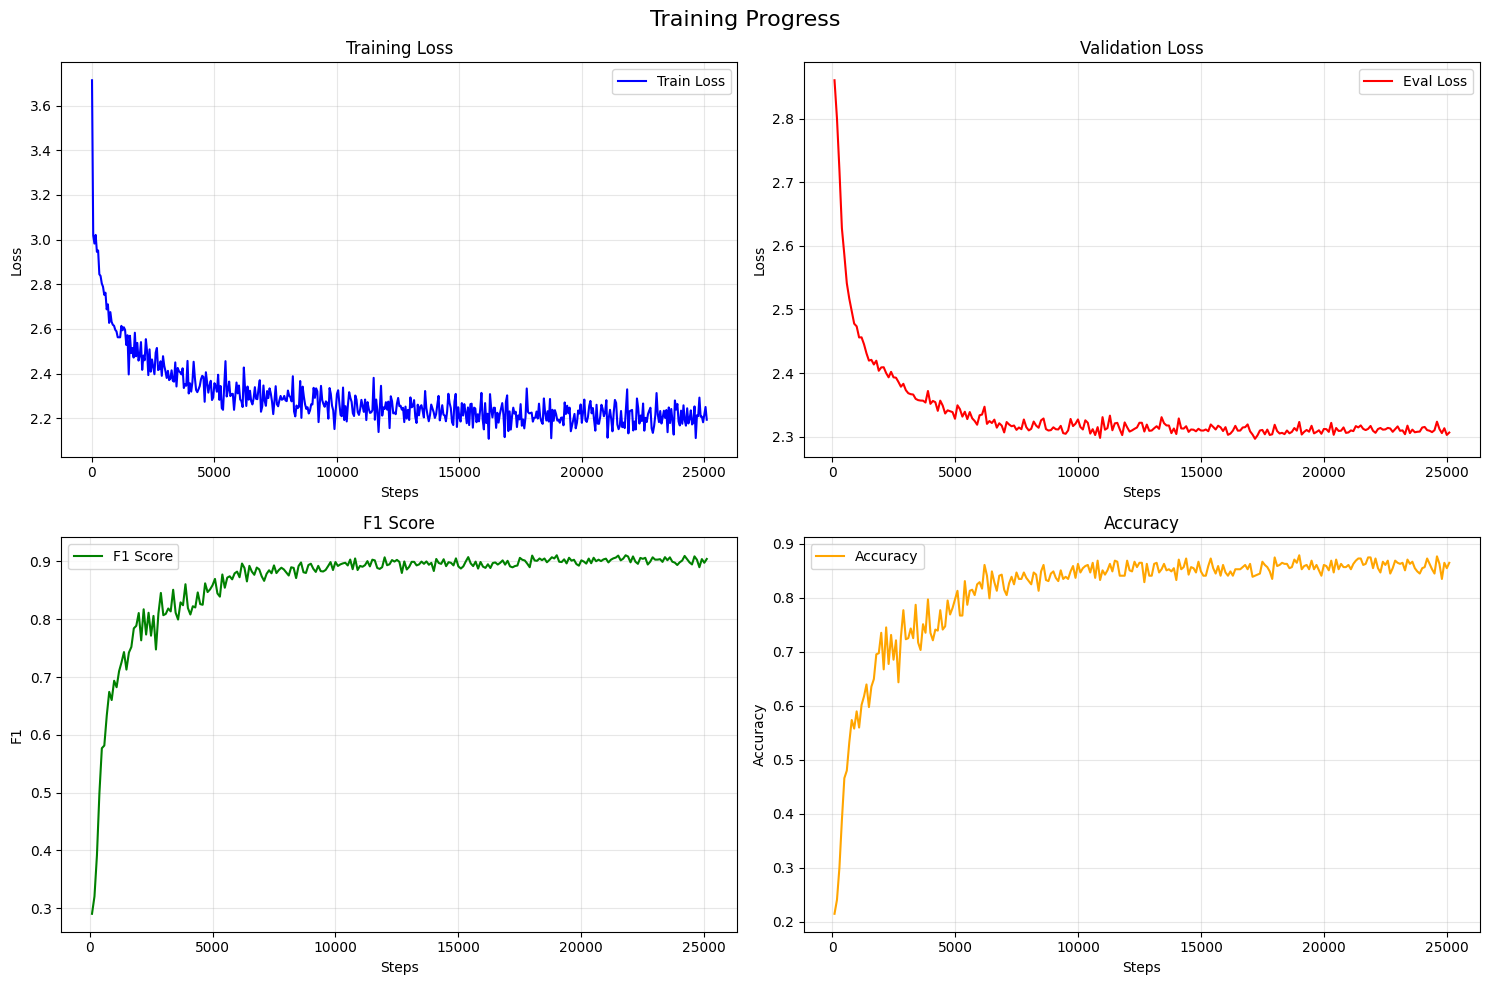


🎯 Final Training Metrics:


In [60]:
# Plot training history

plot_training_history(trainer, CONFIG['base_path'] + 'final_model_enhanced')


# Print final metrics

if trainer.state.log_history:
  final_metrics = trainer.state.log_history[-1]

print("\n🎯 Final Training Metrics:")

for key, value in final_metrics.items():

  if key.startswith('eval_'):
    print(f" {key}: {value:.4f}")